___

# 1. Imports

In [1]:
import os
import shutil
from glob import glob

import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import PIL
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
tqdm.pandas()

In [2]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

In [3]:
training_path = "/storage/datasets/visione-artificiale/Warp-C/all_train/"
test_path = "/storage/datasets/visione-artificiale/Warp-C/all_test/"

img_width = 128
img_height = 128

___

# 2. Load dataset

### 2.1 Load metadata

In [4]:
training_images = list(filter(lambda path: not os.path.isdir(path), glob(training_path+"/*/*")))
test_images = list(filter(lambda path: not os.path.isdir(path), glob(test_path+"/*/*")))

In [5]:
metadata = []
for path in tqdm(training_images + test_images, desc="Loading metadata"):
    width, height = PIL.Image.open(path).size
    metadata.append({
        "path": path,
        "width": width,
        "height": height,
        "label": path.split("/")[6],
        "parent_label": path.split("/")[6].split("-")[0],
        "split": path.split("/")[5].replace("all_", ""),
    })

metadata = pd.DataFrame(metadata)
metadata.sample(5)

Loading metadata:   0%|          | 0/10374 [00:00<?, ?it/s]

path  width  height  \
7     /storage/datasets/visione-artificiale/Warp-C/a...    246     185   
6809  /storage/datasets/visione-artificiale/Warp-C/a...     66     218   
3129  /storage/datasets/visione-artificiale/Warp-C/a...     74     128   
8458  /storage/datasets/visione-artificiale/Warp-C/a...    150     233   
1887  /storage/datasets/visione-artificiale/Warp-C/a...    122     194   

              label parent_label  split  
7          canister     canister  train  
6809   bottle-green       bottle  train  
3129  bottle-transp       bottle  train  
8458  bottle-yogurt       bottle  train  
1887  bottle-blue5l       bottle  train

### 2.2 Load images

In [6]:
# Define the transformation to apply to the images
transform = transforms.Compose([
    transforms.Resize((img_width, img_height)),
    transforms.ToTensor()
])

In [7]:
# Load the train dataset
train_dataset = ImageFolder(root=training_path, transform=transform)

# Load the test dataset
test_dataset = ImageFolder(root=test_path, transform=transform)

# Create data loaders for batching and shuffling the data
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Training images: {len(train_dataset.imgs)}")
print(f"Test images: {len(test_dataset.imgs)}")

Training images: 8823
Test images: 1551


In [8]:
class_labels = train_dataset.classes
num_classes = len(class_labels)

print(f"Dataset loaded with {num_classes} classes:")
print(class_labels)

Dataset loaded with 28 classes:
['bottle-blue', 'bottle-blue-full', 'bottle-blue5l', 'bottle-blue5l-full', 'bottle-dark', 'bottle-dark-full', 'bottle-green', 'bottle-green-full', 'bottle-milk', 'bottle-milk-full', 'bottle-multicolor', 'bottle-multicolorv-full', 'bottle-oil', 'bottle-oil-full', 'bottle-transp', 'bottle-transp-full', 'bottle-yogurt', 'canister', 'cans', 'detergent-box', 'detergent-color', 'detergent-transparent', 'detergent-white', 'glass-dark', 'glass-green', 'glass-transp', 'juice-cardboard', 'milk-cardboard']


___

# 3. Dataset Exploration

### 3.1 Displaying dataset sample

In [9]:
# Iterate over the data loader and plot the images
images, labels = next(iter(train_loader))

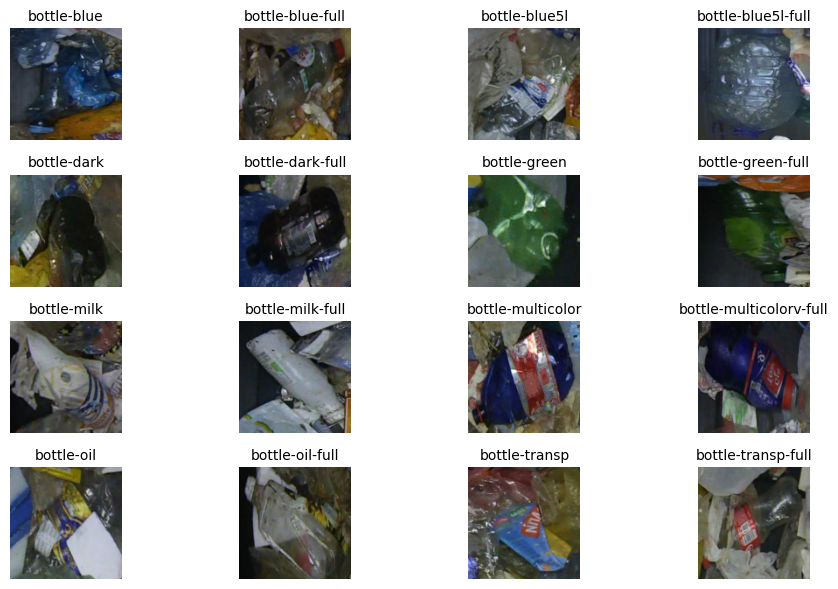

In [10]:
prev_label = None
plot_cnt = 0
grid_rows = 4
grid_cols = 4
fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(10, 6))

for images, labels in train_loader:
    for image, label in zip(images, labels):
        if plot_cnt >= grid_rows * grid_cols:
            break
        if prev_label == label:
            continue
        else:
            prev_label = label
        denorm_image = image #* 0.5 + 0.5  # Assuming normalization with mean 0.5 and std 0.5
        np_image = np.transpose(denorm_image, (1, 2, 0))

        row = plot_cnt // grid_cols
        col = plot_cnt % grid_cols
        axes[row, col].imshow(np_image)
        axes[row, col].set_title(class_labels[label], fontsize=10)
        axes[row, col].axis("off")
        plot_cnt += 1

    if plot_cnt >= grid_rows * grid_cols:
        break

plt.tight_layout()
plt.show()

___

### 3.2 Image dimension distribution

In [11]:
metadata.describe()

width        height
count  10374.000000  10374.000000
mean     185.751494    178.724889
std       92.963640     92.713925
min       40.000000     35.000000
25%      118.000000    107.000000
50%      162.000000    154.000000
75%      228.000000    229.000000
max      703.000000    668.000000

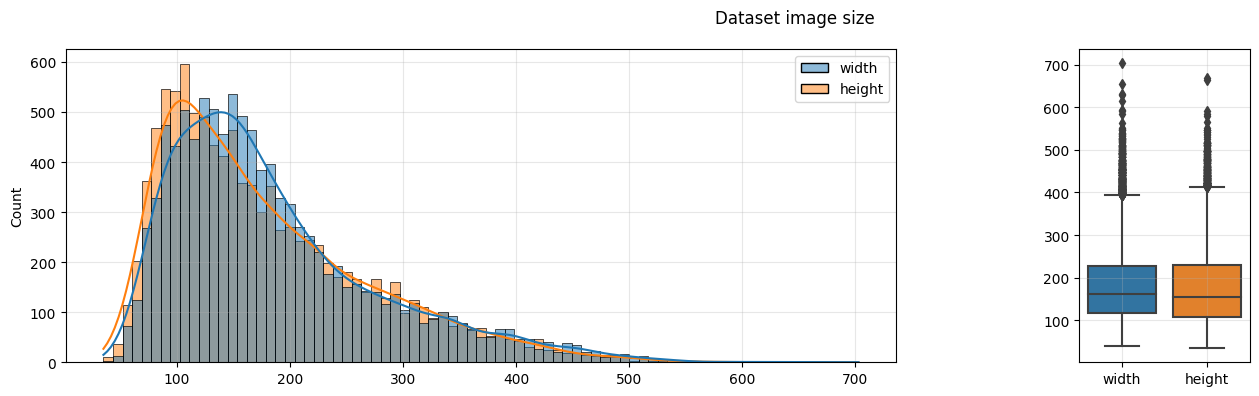

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
fig.suptitle("Dataset image size")

sns.histplot(metadata, kde=True, ax=ax1)
ax1.grid(alpha=.3);

ax2.set_aspect(.005)
sns.boxplot(metadata, ax=ax2);
ax2.grid(alpha=.3);

plt.tight_layout()

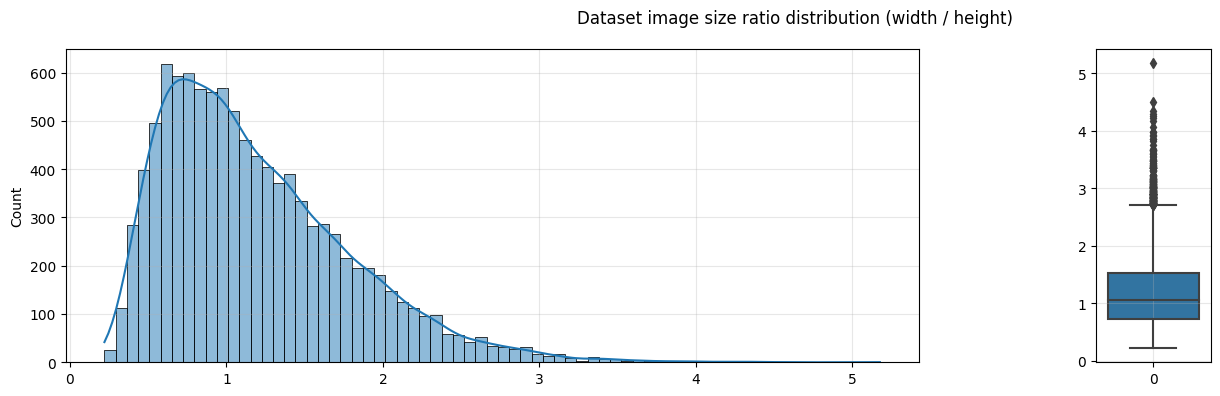

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
fig.suptitle("Dataset image size ratio distribution (width / height)")

sns.histplot(metadata.width / metadata.height, kde=True, ax=ax1)
ax1.grid(alpha=.3);

ax2.set_aspect(.5)
sns.boxplot(metadata.width / metadata.height, ax=ax2);
ax2.grid(alpha=.3);

plt.tight_layout()
plt.show()

In [14]:
# We are choosing the central intersection as the optimal value for both width and height
# Since the image sizes ratio median is around 1, we are going to choose the same optimal values
# Therefore the size chosen for both dimension is 128
optimal_width, optimal_height = 128, 128
print(f"Optimal width: {optimal_width}, optimal height: {optimal_height}")

Optimal width: 128, optimal height: 128


___

### 3.3 Class distribution

In [15]:
# Sort dataframe by label count
sorted_index = metadata["label"].value_counts().index
metadata = metadata.set_index("label").loc[sorted_index].reset_index()

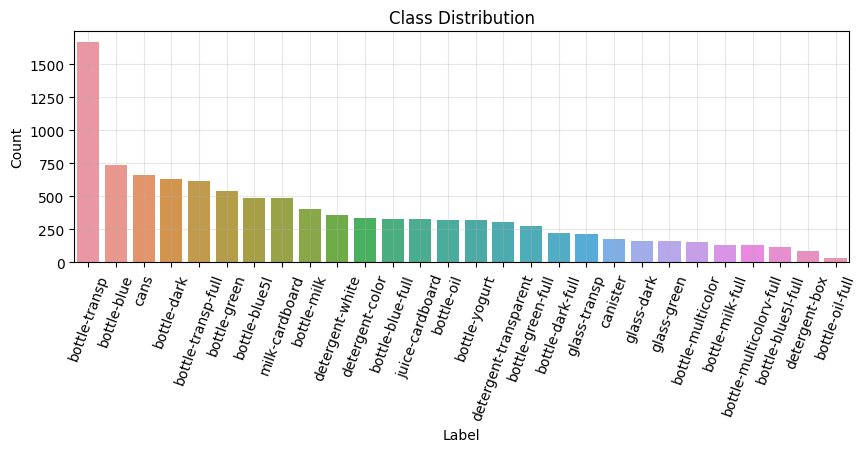

In [16]:
# Label
plt.figure(figsize=(10,3))
plt.title("Class Distribution")
sns.countplot(data=metadata, x="label")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(rotation=70)
plt.grid(alpha=.3)
plt.show()

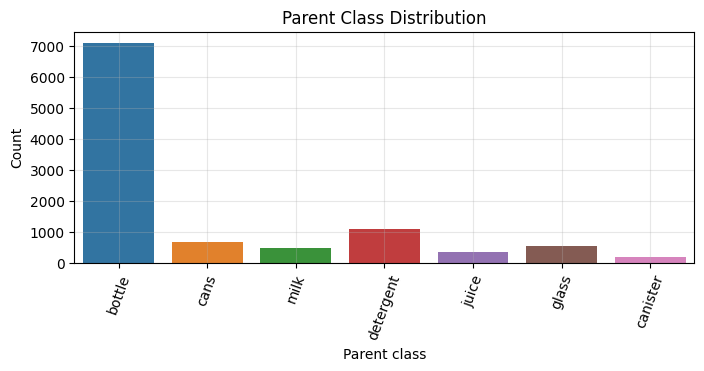

In [17]:
# Parent label
plt.figure(figsize=(8,3))
plt.title("Parent Class Distribution")
sns.countplot(data=metadata, x="parent_label")
plt.xlabel("Parent class")
plt.ylabel("Count")
plt.xticks(rotation=70)
plt.grid(alpha=.3)
plt.show()

___

# 4. Dataset Balancing

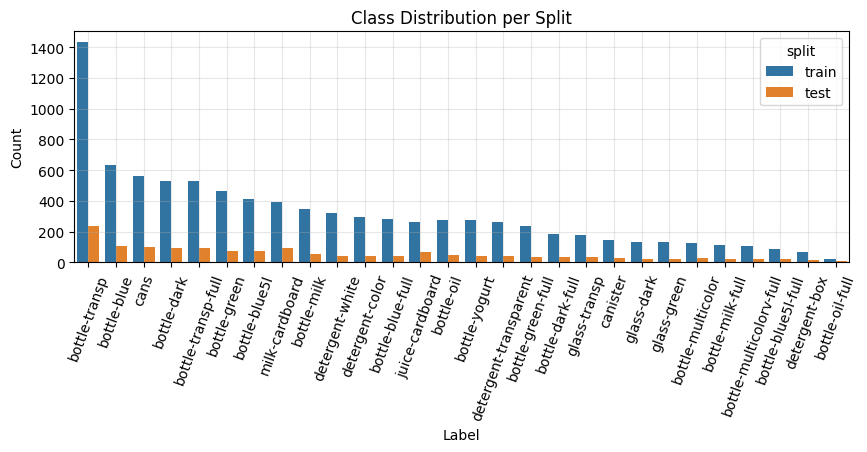

In [18]:
# Label
plt.figure(figsize=(10,3))
plt.title("Class Distribution per Split")
sns.countplot(data=metadata, x="label", hue="split")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(rotation=70)
plt.grid(alpha=.3)
plt.show()

* Dataset is imbalanced because of the bottle class. The particular imbalanced label is "bottle-transp"
* We are going to reduce bottle-transp to the same amount second most common class, which is bottle-blue with 634 entries.
* Reduction will be made on the training set, which resulted with too entries

### Removing classes from dataset

In [19]:
metadata[["label", "split"]].value_counts()[:2]

label          split
bottle-transp  train    1432
bottle-blue    train     634
Name: count, dtype: int64

In [20]:
class_to_balance = "bottle-transp"
entries_to_remove = 1432 - 634
print(f"Removing {entries_to_remove} entries from '{class_to_balance}' class")

Removing 798 entries from 'bottle-transp' class


In [21]:
index_to_remove = metadata[(metadata.label == class_to_balance) & (metadata.split == "train")].sample(entries_to_remove).index
removed_files = metadata.loc[index_to_remove].copy()
len(index_to_remove)

798

In [22]:
metadata.drop(index_to_remove, inplace=True)
print(f"Dataset reduced to {metadata.shape} entries")

Dataset reduced to (9576, 6) entries


In [23]:
metadata.split.value_counts()

split
train    8025
test     1551
Name: count, dtype: int64

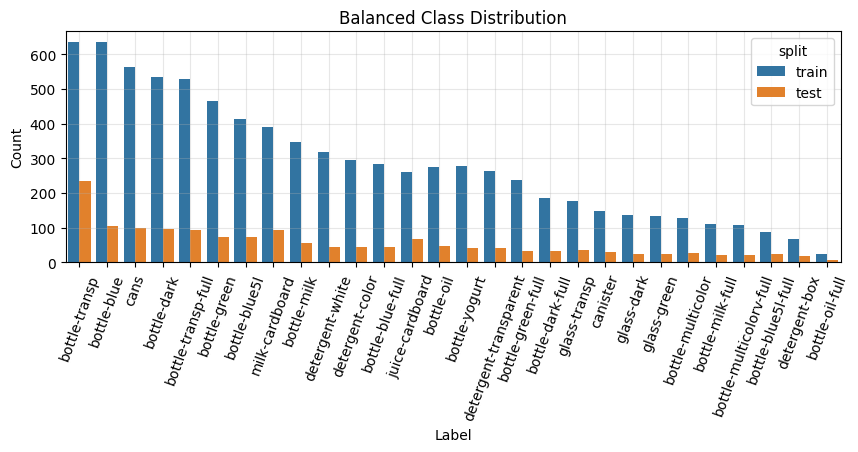

In [24]:
# Label
plt.figure(figsize=(10,3))
plt.title("Balanced Class Distribution")
sns.countplot(data=metadata, x="label", hue="split")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(rotation=70)
plt.grid(alpha=.3)
plt.show()

___

# 5. Training, test, validation split

### 5.1 Creating splits

In [25]:
validation_size = .1
print(f"Creating {validation_size*100}% validation split from training entries.")

Creating 10.0% validation split from training entries.


In [26]:
training_entries = metadata[metadata.split == "train"]
training_entries

label                                               path  \
1        bottle-transp  /storage/datasets/visione-artificiale/Warp-C/a...   
6        bottle-transp  /storage/datasets/visione-artificiale/Warp-C/a...   
7        bottle-transp  /storage/datasets/visione-artificiale/Warp-C/a...   
8        bottle-transp  /storage/datasets/visione-artificiale/Warp-C/a...   
17       bottle-transp  /storage/datasets/visione-artificiale/Warp-C/a...   
...                ...                                                ...   
10361  bottle-oil-full  /storage/datasets/visione-artificiale/Warp-C/a...   
10362  bottle-oil-full  /storage/datasets/visione-artificiale/Warp-C/a...   
10363  bottle-oil-full  /storage/datasets/visione-artificiale/Warp-C/a...   
10364  bottle-oil-full  /storage/datasets/visione-artificiale/Warp-C/a...   
10365  bottle-oil-full  /storage/datasets/visione-artificiale/Warp-C/a...   

       width  height parent_label  split  
1        246     118       bottle  train  
6        130     110       bottle  train  
7        215     421       bottle  train  
8        156      89       bottle  train  
17       151      92       bottle  train  
...      ...     ...          ...    ...  
10361    198      64       bottle  train  
10362    145     290       bottle  train  
10363    232     232       bottle  train  
10364    192     129       bottle  train  
10365    310     129       bottle  train  

[8025 rows x 6 columns]

In [27]:
X_train, X_valid, y_train, y_valid = train_test_split(
    training_entries,
    training_entries.label,
    test_size=validation_size,
    stratify=training_entries.label,
    random_state=42
)

In [28]:
metadata_valid = metadata.copy()
metadata_valid.loc[X_valid.index, "split"] = "validation"

### 5.2 Final label distribution

In [29]:
### Class distribution among splits
metadata_group = metadata_valid.groupby(["label", "split"])[["label", "split"]].size().reset_index(name="count")
total_counts = metadata_group.groupby(["label"])["count"].transform("sum")
metadata_group["percentage"] = metadata_group["count"] / total_counts * 100
display(metadata_group.head())

pivot = metadata_group.pivot(index="label", columns="split", values="count").sort_values(by="train", ascending=False)[["train", "test", "validation"]]
pivot.plot(kind='bar', stacked=True, title="Class distribution among splits", figsize=(12,3));
plt.legend(loc="upper right");
plt.grid(alpha=.3)

label       split  count  percentage
0       bottle-blue        test    104   14.092141
1       bottle-blue       train    571   77.371274
2       bottle-blue  validation     63    8.536585
3  bottle-blue-full        test     43   13.109756
4  bottle-blue-full       train    257   78.353659

___

# 6. Exporting dataset

In [30]:
metadata_valid.split.value_counts()

split
train         7222
test          1551
validation     803
Name: count, dtype: int64

In [31]:
balanced_folder = "/storage/datasets/visione-artificiale/Warp-C/"

### Deleting folder contents
!rm -r $balanced_folder/train_balanced
!rm -r $balanced_folder/test_balanced
!rm -r $balanced_folder/validation_balanced

In [32]:
### Copying files
def copy_image(entry):
    output_dir = f"{balanced_folder}/{entry.split}_balanced/{entry.label}/"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    shutil.copy(entry.path, output_dir)

metadata_valid.progress_apply(copy_image, axis=1)
print("Dataset exported.")

  0%|          | 0/9576 [00:00<?, ?it/s]

Dataset exported.


___

# 7. Dataset normalization

In [33]:
# Load balanced test dataset
balanced_train_path = os.path.join(balanced_folder, "train_balanced")
balanced_train_dataset = ImageFolder(root=balanced_train_path, transform=transform)

In [34]:
# Create data loaders for batching and shuffling the data
balanced_train_loader = torch.utils.data.DataLoader(balanced_train_dataset, batch_size=64, shuffle=True)

print(f"Training images: {len(balanced_train_dataset.imgs)}")

Training images: 7222


### 7.1 Mean/STD distribution per channel

In [35]:
### All images chanel mean/std
num_samples = 0
dataset_channel_stats = []

for images, _ in tqdm(balanced_train_loader):
    
    for image in images:
        dataset_channel_stats.append({
            "μ_Channel_0": image[0].mean().item(),
            "μ_Channel_1": image[1].mean().item(),
            "μ_Channel_2": image[2].mean().item(),

            "σ_Channel_0": image[0].std().item(),
            "σ_Channel_1": image[1].std().item(),
            "σ_Channel_2": image[2].std().item(),
        })
dataset_channel_stats = pd.DataFrame(dataset_channel_stats)
dataset_channel_stats.head(5)

  0%|          | 0/113 [00:00<?, ?it/s]

μ_Channel_0  μ_Channel_1  μ_Channel_2  σ_Channel_0  σ_Channel_1  \
0     0.509258     0.531529     0.562053     0.311816     0.302412   
1     0.511827     0.601072     0.391052     0.119705     0.145695   
2     0.257122     0.264021     0.194410     0.185667     0.165002   
3     0.237780     0.229154     0.250460     0.162179     0.125825   
4     0.402884     0.368055     0.373888     0.188363     0.173331   

   σ_Channel_2  
0     0.283210  
1     0.191940  
2     0.160506  
3     0.135165  
4     0.181901

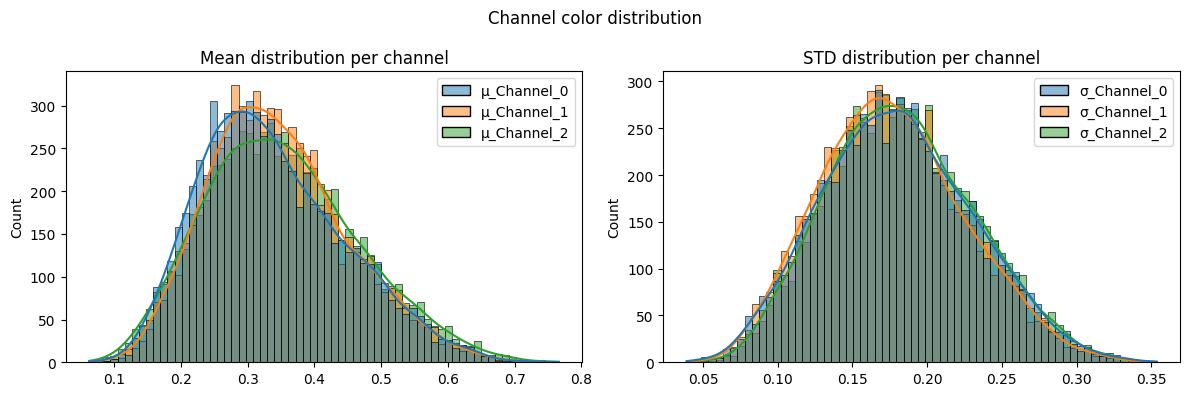

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle("Channel color distribution")

ax1.set_title("Mean distribution per channel")
sns.histplot(dataset_channel_stats[["μ_Channel_0", "μ_Channel_1", "μ_Channel_2"]], kde=True, ax=ax1)

ax2.set_title("STD distribution per channel")
sns.histplot(dataset_channel_stats[["σ_Channel_0", "σ_Channel_1", "σ_Channel_2"]], kde=True, ax=ax2)

plt.tight_layout()
plt.show()

In [37]:
### Mean
channels_stats = dataset_channel_stats.mean(axis=0)
channels_stats

μ_Channel_0    0.337328
μ_Channel_1    0.345371
μ_Channel_2    0.351522
σ_Channel_0    0.180599
σ_Channel_1    0.176688
σ_Channel_2    0.183028
dtype: float64

___

### 7.2 Testing color-normalized dataset

In [38]:
# Define the transformation to apply to the images
color_norm_transform = transforms.Compose([
    transforms.Resize((optimal_width, optimal_height)), # Resize the images to a specific size
    transforms.ToTensor(), # Convert images to tensors
    transforms.Normalize(
        mean=(channels_stats.μ_Channel_0, channels_stats.μ_Channel_1, channels_stats.μ_Channel_2),
        std=(channels_stats.σ_Channel_0, channels_stats.σ_Channel_1, channels_stats.σ_Channel_2)
    )
])

In [39]:
normalized_train_dataset = ImageFolder(root=balanced_train_path, transform=color_norm_transform)
normalized_train_loader = torch.utils.data.DataLoader(normalized_train_dataset, batch_size=64, shuffle=False)

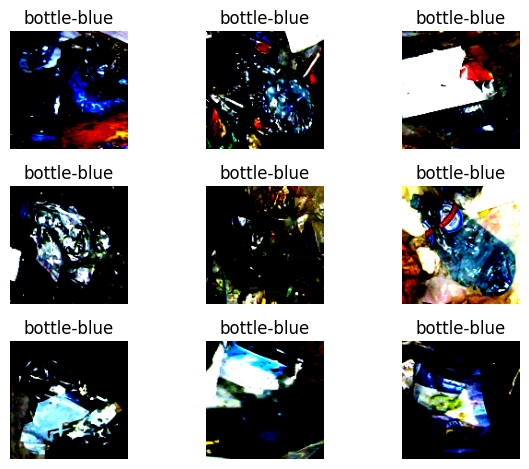

In [41]:
# Iterate over the data loader and plot the images
images, labels = next(iter(normalized_train_loader))
for i, (image, label) in enumerate(zip(images, labels)):
    if i >= 9: break
    image = np.clip(image, 0, 1) # Clipping because normalization changes color ranges
    image = np.transpose(image, (1, 2, 0))
    
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(image)
    plt.title(class_labels[label])
    plt.axis("off")

plt.tight_layout()
plt.show()

In [42]:
import random

# Get random batches of images and labels
random_batches = random.sample(list(normalized_train_loader), k=9)

In [43]:
# Plot the random images from each batch
for i, batch in enumerate(random_batches):
    batch_images, batch_labels = batch
    random_index = random.randint(0, len(batch_images) - 1)
    image = batch_images[random_index]
    label = batch_labels[random_index]

    image = np.clip(image, 0, 1)  # Clipping because normalization changes color ranges
    image = np.transpose(image, (1, 2, 0))

    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(class_labels[label])
    plt.axis("off")

plt.tight_layout()
plt.show()

___

# 8. Data Augmentation

In [44]:
### We define a set of transformation that will be applied during the training
### We are always going to apply those aumgentations to resized images

In [45]:
### Load a sample of images
samples = metadata.sample(5).reset_index(drop=True)
samples

label                                               path  \
0     bottle-transp-full  /storage/datasets/visione-artificiale/Warp-C/a...   
1           bottle-green  /storage/datasets/visione-artificiale/Warp-C/a...   
2  detergent-transparent  /storage/datasets/visione-artificiale/Warp-C/a...   
3            bottle-blue  /storage/datasets/visione-artificiale/Warp-C/a...   
4           bottle-green  /storage/datasets/visione-artificiale/Warp-C/a...   

   width  height parent_label  split  
0    307     264       bottle  train  
1    198     314       bottle  train  
2    231     219    detergent  train  
3    177     124       bottle  train  
4    194     122       bottle  train

### 8.1 Define Transformations

In [46]:
augmentation_transformations = [
    transforms.RandomHorizontalFlip(p=1),
    transforms.RandomVerticalFlip(p=1),
    transforms.RandomApply([transforms.RandomRotation(degrees=45)], p=1),
    transforms.RandomPerspective(distortion_scale=0.3, p=1),
    transforms.RandomEqualize(p=1),
    transforms.RandomAdjustSharpness(sharpness_factor=5, p=1),
    transforms.RandomAutocontrast(p=1),
]

### 8.2 Visualize Transformations

Applying transformations - Label: bottle-transp-full


Applying transformations - Label: bottle-green


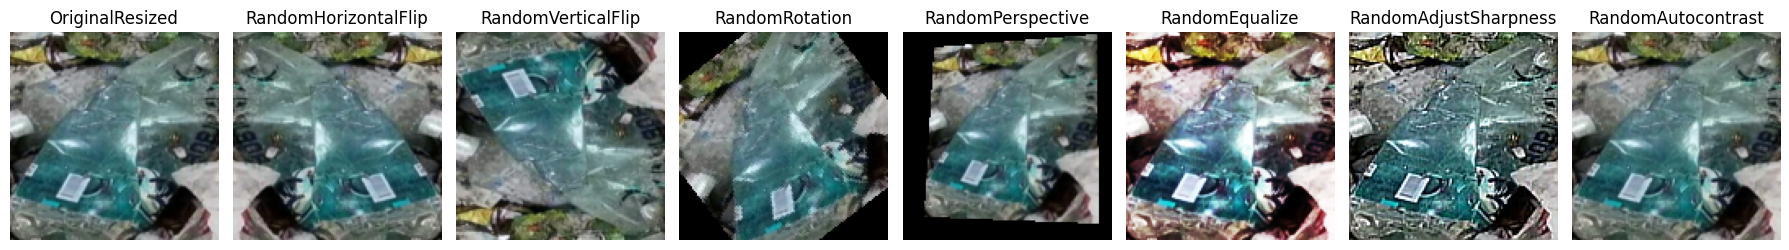

Applying transformations - Label: detergent-transparent


Applying transformations - Label: bottle-blue


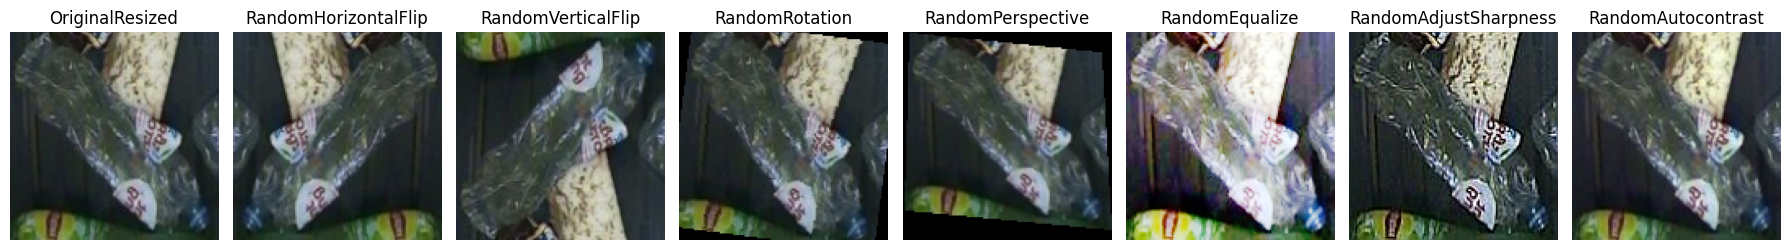

Applying transformations - Label: bottle-green


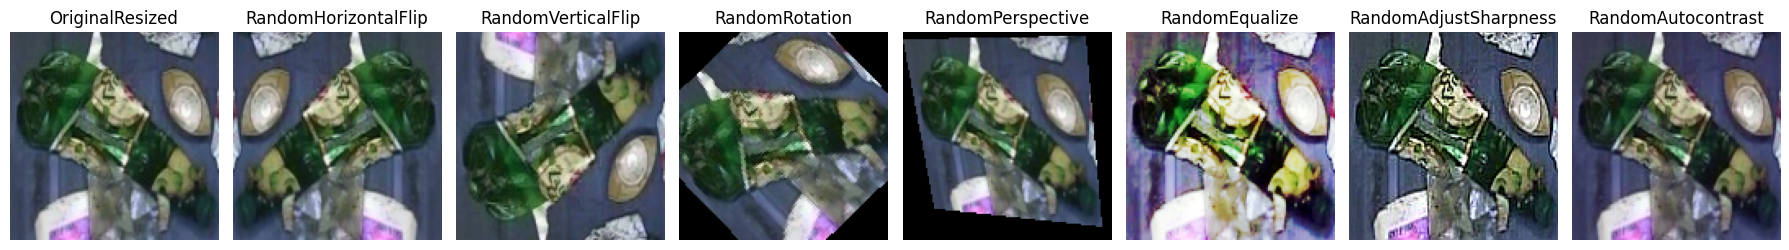

In [47]:
for _, entry in samples.iterrows():
    print(f"Applying transformations - Label: {entry.label}")
    # Load image and resize
    image = PIL.Image.open(entry.path)
    image = transforms.Resize((optimal_width, optimal_height))(image)

    fig, axs = plt.subplots(nrows=1, ncols=len(augmentation_transformations)+1, figsize=(18, 4))

    # Display original but resized image
    axs[0].set_title("OriginalResized")
    axs[0].imshow(image)
    axs[0].axis("off")

    # Display augmentation transformations
    for idx, T in enumerate(augmentation_transformations, start=1):
        t_name = T.__class__.__name__
        t_name = t_name if t_name != "RandomApply" else T.transforms[0].__class__.__name__
        
        image_aug = T(image)
        axs[idx].set_title(t_name)
        axs[idx].imshow(image_aug)
        axs[idx].axis("off")

    plt.tight_layout()
    plt.show()